# Batch discriminator

Goal: Neuronal network that can distinguish between batches of the large atac gene activity data set

In [3]:
#import numpy and keras modules
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

#import Scanpy modules
import scanpy as sc
import anndata as ad

#import os and matplotlib
import os
import matplotlib 
import matplotlib.pyplot as plt

#import sklearn modules
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

# Set a random seed for reproducibility
random_seed = 42

## Load data

In [4]:
#set base path to load data: goes back one directory and then into the data
base_path = os.path.join('..', 'data')

#Name of data set
dataset_name = 'Lung_atlas_public'

# read dataset into an anndata object:  Category - Cells of the brain
inPath = os.path.join(base_path, f"{dataset_name}.h5ad")
adata = sc.read(inPath)
adata.obs

,dataset,location,nGene,nUMI,patientGroup,percent.mito,protocol,sanger_type,size_factors,sampling_method,batch,cell_type,donor
index,,,,,,,,,,,,,
GAGGGGCCAGCC,Dropseq_transplant,Dropseq_lower,249,355,nan,0.019718,drop-seq,drop-seq,0.381231,Transplant,B1,Type 2,B1
ACATAGATAGGC,Dropseq_transplant,Dropseq_lower,582,987,nan,0.044580,drop-seq,drop-seq,1.081643,Transplant,B1,Type 2,B1
ATCGACGCGGCA,Dropseq_transplant,Dropseq_lower,292,490,nan,0.026531,drop-seq,drop-seq,0.497352,Transplant,B1,Type 2,B1
CCAGCTTAGGTT,Dropseq_transplant,Dropseq_lower,1057,1806,nan,0.035437,drop-seq,drop-seq,2.172617,Transplant,B1,Type 2,B1
TCATAGAGTCCT,Dropseq_transplant,Dropseq_lower,716,1378,nan,0.020319,drop-seq,drop-seq,1.197578,Transplant,B1,Type 2,B1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
LungTranscriptome7239219_LungTranscriptome7239219GGGCATCCACCAACCG,10x_Transplant,Transplant,1178,3245,Parenchyma,0.011896,10x v2,other,0.775650,Transplant,5,Mast cell,5
LungTranscriptome7239219_LungTranscriptome7239219TGCTGCTAGCAATCTC,10x_Transplant,Transplant,1919,5984,Parenchyma,0.018747,10x v2,other,0.982236,Transplant,5,Mast cell,5
LungTranscriptome7239213_GACTGCGTCCTGCCAT,10x_Transplant,Transplant,4411,25233,Parenchyma,0.010489,10x v2,other,1.235763,Transplant,3,Mast cell,3


## Look at Data and Plot it

In [5]:
#Lets look at the data
X_numpy = adata.X.toarray()
print(X_numpy.shape) # array: each row corresponding to one cell, each collumn to one gene

#Metadata
adata.obs["batch"] #  16 batches

(32472, 15148)


index
GAGGGGCCAGCC                                                         B1
ACATAGATAGGC                                                         B1
ATCGACGCGGCA                                                         B1
CCAGCTTAGGTT                                                         B1
TCATAGAGTCCT                                                         B1
                                                                     ..
LungTranscriptome7239219_LungTranscriptome7239219GGGCATCCACCAACCG     5
LungTranscriptome7239219_LungTranscriptome7239219TGCTGCTAGCAATCTC     5
LungTranscriptome7239213_GACTGCGTCCTGCCAT                             3
LungTranscriptome7239218_GCTGCGACATTCACTT                             6
LungTranscriptome7239219_LungTranscriptome7239219TTAGGACGTGACGGTA     5
Name: batch, Length: 32472, dtype: category
Categories (16, object): ['1', '2', '3', '4', ..., 'B1', 'B2', 'B3', 'B4']

In [24]:
adata.obs["cell_type"] #  16 batches

index
GAGGGGCCAGCC                                                            Type 2
ACATAGATAGGC                                                            Type 2
ATCGACGCGGCA                                                            Type 2
CCAGCTTAGGTT                                                            Type 2
TCATAGAGTCCT                                                            Type 2
                                                                       ...    
LungTranscriptome7239219_LungTranscriptome7239219GGGCATCCACCAACCG    Mast cell
LungTranscriptome7239219_LungTranscriptome7239219TGCTGCTAGCAATCTC    Mast cell
LungTranscriptome7239213_GACTGCGTCCTGCCAT                            Mast cell
LungTranscriptome7239218_GCTGCGACATTCACTT                            Mast cell
LungTranscriptome7239219_LungTranscriptome7239219TTAGGACGTGACGGTA    Mast cell
Name: cell_type, Length: 32472, dtype: category
Categories (17, object): ['B cell', 'Basal 1', 'Basal 2', 'Ciliated', ..., 'S

In [6]:
#Metadata names to color graph later on
label_key = 'cell_type'
batch_key = 'batch'

#Options for plotting
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.set_figure_params(dpi_save=300)

# Dimensionality Reduction of Data
sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=25)
sc.tl.umap(adata, random_state=42)


c:\Users\lklei\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


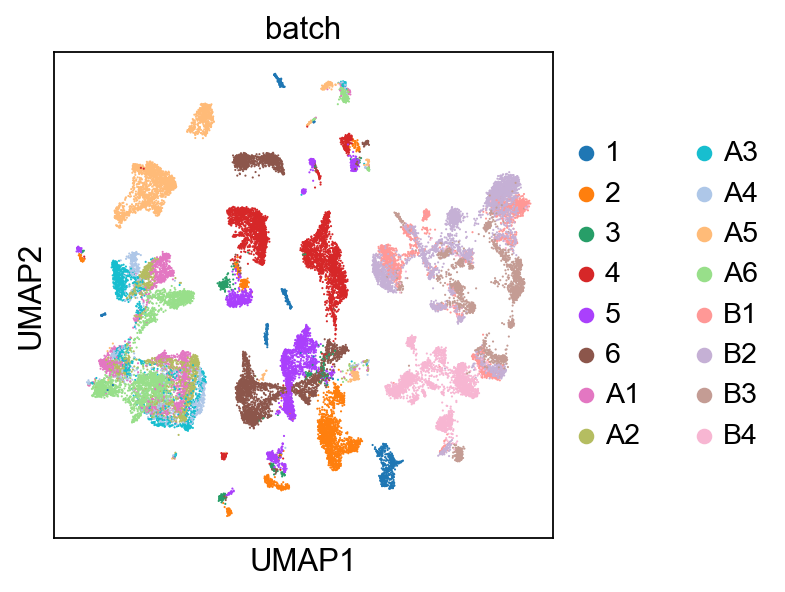

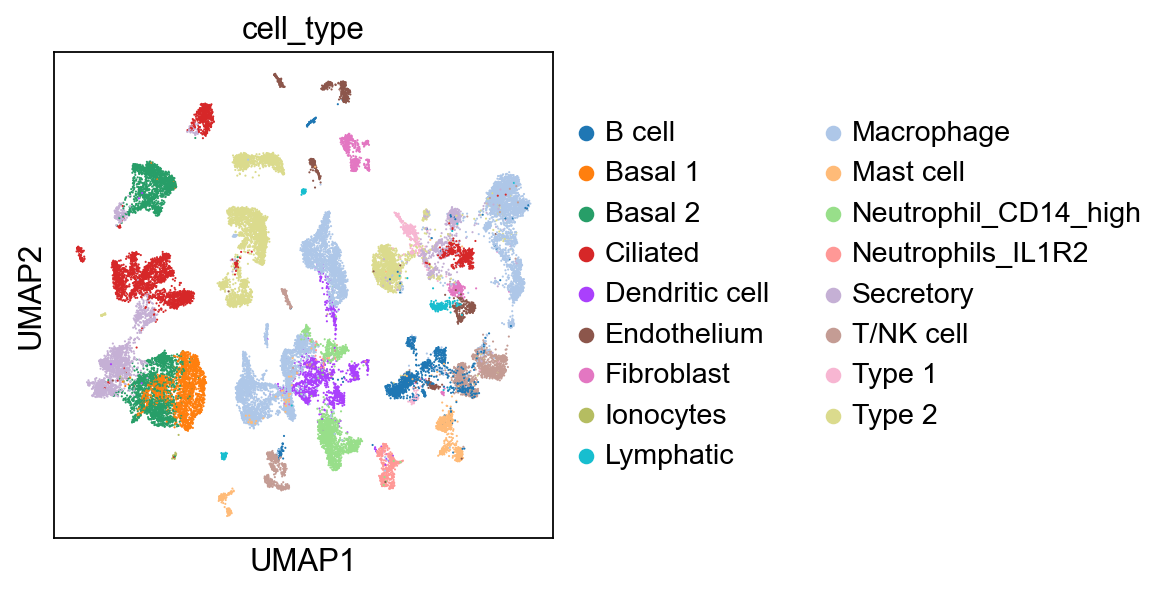

In [7]:
# --- Plot original data ---
sc.pl.umap(adata, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[batch_key], show=True, use_raw=False) #coloured by batch: batch effect present
sc.pl.umap(adata, palette=matplotlib.rcParams["axes.prop_cycle"],
           color=[label_key], show=True, use_raw=False) #coloured by cell type

## Batch discriminator
#### Input: Gen expression vector xi and cell label tl (hot-encoded)
#### Output: Probability distribution over 11 batches
#### Loss function: categorical cross-entropy (predicted probabilities vs. true batch labels)

In [8]:
#---Prepare Data---
#Encode the cell labels as One hot vector to use as additional information
encoder = OneHotEncoder(sparse_output=False)  # `sparse=False` returns a dense array
encoded_labels = encoder.fit_transform(adata.obs[['final_cell_label']])

# Concatenate gen expreesion matrix with oneHotLabels
INPUT = np.concatenate((X_numpy, encoded_labels), axis=1)
INPUT.shape[1]-X_numpy.shape[1] # 7 extra X values for the one-hot encoding

#One-hot encoded Batches
encoder = OneHotEncoder(sparse_output=False)  # `sparse=False` returns a dense array
OUTPUT = encoder.fit_transform(adata.obs[['batchname_all']])

#Perform a Train Test Split
INPUT_train, INPUT_test, OUTPUT_train, OUTPUT_test = train_test_split(INPUT, OUTPUT, test_size=0.2, random_state=random_seed)

#Output and Input size of NN
INPUT_size = INPUT[0].size
OUTPUT_size = OUTPUT[0].size



In [14]:
#---Build the model---
#Initilize the model
model = Sequential()
#Define Hyperparameters
OPTIMIZER = 'adam'                  #optimizer
LOSS = 'categorical_crossentropy'   # loss function
N_HIDDEN = 256                      # Number of nodes in hidden layers
ACTIVATION_FUNCTION = 'relu'        #activation function
L2_LAMBDA = 0.0075                   # Regularization strength

# First hidden layer with L2 regularization
model.add(Dense(N_HIDDEN, input_shape=(INPUT_size,), activation=ACTIVATION_FUNCTION, kernel_regularizer=l2(L2_LAMBDA)))

# Second hidden layer with L2 regularization
model.add(Dense(128, activation='relu', kernel_regularizer=l2(L2_LAMBDA)))

# Output layer (softmax for multi-class classification)
model.add(Dense(OUTPUT_size, activation='softmax'))

# Summary of the whole model
model.summary()

# model compilation
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

c:\Users\lklei\anaconda3\envs\Tensorflow\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │       918,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 952,843 (3.63 MB)

 Trainable params: 952,843 (3.63 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#---Train the model---
#Hyperparameters
BATCH_SIZE = 32
N_EPOCH = 15

#Fit the input to the output
history = model.fit(INPUT_train, OUTPUT_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=2, validation_split=0.2)

#test the network
score = model.evaluate(INPUT_test, OUTPUT_test, verbose=2)
print("\nTest score/loss:", score[0])
print("Test accuracy:", score[1])


Epoch 1/15
1697/1697 - 6s - 4ms/step - accuracy: 0.3776 - loss: 2.1253 - val_accuracy: 0.4189 - val_loss: 1.7685
Epoch 2/15
1697/1697 - 5s - 3ms/step - accuracy: 0.4360 - loss: 1.7081 - val_accuracy: 0.4575 - val_loss: 1.6271
Epoch 3/15
1697/1697 - 5s - 3ms/step - accuracy: 0.4668 - loss: 1.6046 - val_accuracy: 0.4717 - val_loss: 1.5822
Epoch 4/15
1697/1697 - 5s - 3ms/step - accuracy: 0.4782 - loss: 1.5560 - val_accuracy: 0.4751 - val_loss: 1.5500
Epoch 5/15
1697/1697 - 5s - 3ms/step - accuracy: 0.4890 - loss: 1.5264 - val_accuracy: 0.4760 - val_loss: 1.5323
Epoch 6/15
1697/1697 - 5s - 3ms/step - accuracy: 0.4940 - loss: 1.5050 - val_accuracy: 0.4769 - val_loss: 1.5242
Epoch 7/15
1697/1697 - 5s - 3ms/step - accuracy: 0.4982 - loss: 1.4863 - val_accuracy: 0.4813 - val_loss: 1.5134
Epoch 8/15
1697/1697 - 5s - 3ms/step - accuracy: 0.4987 - loss: 1.4783 - val_accuracy: 0.4859 - val_loss: 1.4944
Epoch 9/15
1697/1697 - 5s - 3ms/step - accuracy: 0.5019 - loss: 1.4710 - val_accuracy: 0.4780 - 

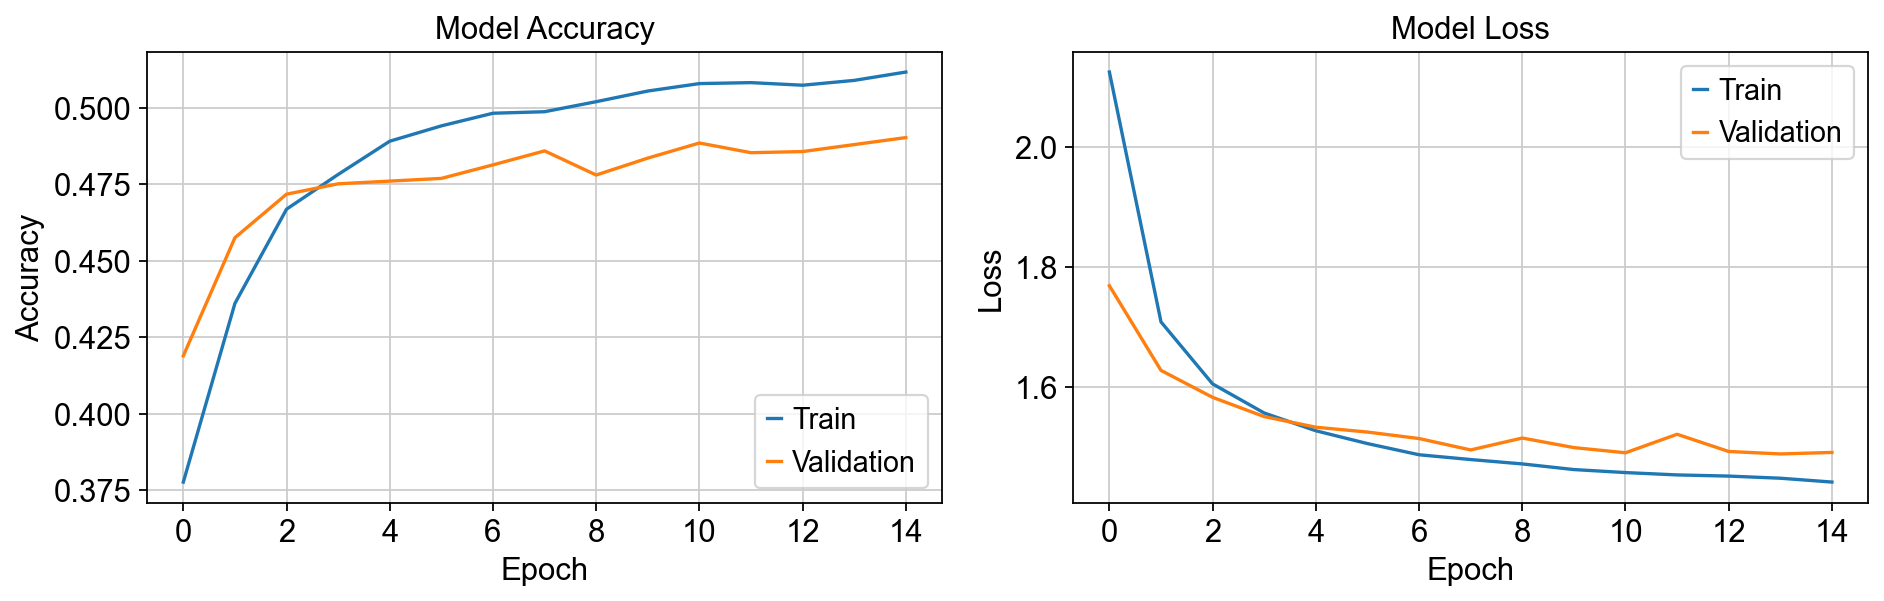

In [16]:
#--Visualisize Training---
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()
#Plots show Accuracy improvment with training and loss decreasing only with Train and validation data: no overfitting
#But: Accuracy a bit low 50% succsses rate for batches 